## Load dependencies

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import pickle
import json
import matplotlib.pyplot as plt
from lstm import LSTM_Simple
from metrics import exact_match_metric, exact_match_metric_index
from callbacks import NValidationSetsCallback, GradientLogger
from tqdm import tqdm
from evaluate_lstm import LSTM_Evaluator

import sys
sys.path.append('../../')
from src.models.attention import LSTMWithAttention
from src.models.generator import DataGenerator, DataGeneratorAttention

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
print(tf.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

2.0.0-alpha0
GPU Available:  True


## Helper Function

In [3]:
def plot_two_results(result_1, result_2=None, experiments=['L&L'], title=''):
    labels = []
    array_1 = []
    array_2 = []
    
    for module in result_1:
        labels.append(module.split('__')[1])
        array_1.append(result_1[module])

    if result_2 is not None:
        for module in result_1:
            array_2.append(result_2[module])

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    if result_2 is not None:
        rects1 = ax.bar(x - width/2, array_1, width, label=experiments[0])
        rects2 = ax.bar(x + width/2, array_2, width, label=experiments[1])
    else:
        rects1 = ax.bar(x, array_1, width, label=experiments[0])


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Evaluation scores: ' + title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    if result_2 is not None:
        autolabel(rects2)

    autolabel(rects1)

    fig.tight_layout()
    plt.ylim([0, 1.1])
    plt.legend(loc='lower right')
    plt.show()

In [4]:
def concatenate_texts_individual(path, pattern):
    file_paths = list(path.glob('{}*.txt'.format(pattern)))
    
    input_texts = {}
    target_texts = {}

    for file_path in file_paths:
        if file_path.stem not in input_texts:
            input_texts[file_path.stem] = []
            target_texts[file_path.stem] = []
        
        with open(str(file_path), 'r', encoding='utf-8') as f:
            lines = f.read().split('\n')[:-1]

        input_texts[file_path.stem].extend(lines[0::2])
        target_texts[file_path.stem].extend(['\t' + target_text + '\n' for target_text in lines[1::2]])
        
    return input_texts, target_texts

In [30]:
def get_data(settings_path):
    with open(str(settings_path), 'r') as file:
        settings_dict = json.load(file)

    raw_path = Path(settings_dict['data_path'])/'raw/v1.0/'
    interpolate_path = raw_path/'interpolate'
    extrapolate_path = raw_path/'extrapolate'
    train_easy_path = raw_path/'train-easy/'
    
    
    math_module = settings_dict["math_module"]
    train_level = settings_dict["train_level"]

    datasets = {
        'train':(raw_path, 'train-' + train_level + '/' + math_module),
        'interpolate':(interpolate_path, math_module),
        'extrapolate':(extrapolate_path, math_module)
               }

    input_texts = {}
    target_texts = {}

    for k, v in datasets.items():
        input_texts[k], target_texts[k] = concatenate_texts_individual(v[0], v[1])
    
    return settings_dict, input_texts, target_texts

In [38]:
def evaluate_arithmetics_interpolate(lstm_eval, input_texts, target_texts, print_res=False):
    test_set = 'interpolate'
    results = {}

    results_deepmind = {'arithmetic__add_or_sub': 0.875,
                        'arithmetic__add_or_sub_in_base': 0.925,
                        'arithmetic__add_sub_multiple': .89,
                        'arithmetic__mul_div_multiple': .91,
                        'arithmetic__nearest_integer_root': .9,
                        'arithmetic__mul': 0.55,
                        'arithmetic__div': 0.82,
                        'arithmetic__simplify_surd':0.08,
                        'arithmetic__mixed': 0.4}

    for module in input_texts[test_set]:
        metric = lstm_eval.evaluate_model(input_texts[test_set][module], target_texts[test_set][module])
        if print_res:
            print(test_set, module)
            print('metric:', metric, '\n')        
        results[module] = metric

    plot_two_results(results, results_deepmind, experiments=['L&L', 'DM'], title='interpolation')
    
    return results, results_deepmind

In [40]:
def evaluate_arithmetics_extrapolate(lstm_eval, input_texts, target_texts, print_res=False):
    test_set = 'extrapolate'
    results = {}

    results_deepmind = {'arithmetic__add_or_sub_big': 0.82,
                        'arithmetic__add_sub_multiple_longer': 0.22,
                        'arithmetic__mul_big': .31,
                        'arithmetic__mixed_longer': 0.02,
                        'arithmetic__mul_div_multiple_longer': 0.34,
                        'arithmetic__div_big':0.64}

    for module in input_texts[test_set]:
        
        metric = lstm_eval.evaluate_model(input_texts[test_set][module], target_texts[test_set][module])
        if print_res:
            print(test_set, module)
            print('metric:', metric, '\n')
        results[module] = metric

    plot_two_results(results, results_deepmind, experiments=['L&L', 'DM'], title='extrapolation')
    return results, results_deepmind

In [8]:
class LSTMWithAttentionEvaluator:
    
    def __init__(self, path):
        
        with open(str(path/'settings.json'), 'r') as file:
            self.settings_dict = json.load(file)

        with open(str(path/'arithmetic-*.pkl'), 'rb') as file:
            self.sequence_data = pickle.load(file) 
            self.token_index = self.sequence_data['input_token_index']

        self.num_tokens = len(self.token_index)
        
        adam = Adam(lr=6e-4, beta_1=0.9, beta_2=0.995, epsilon=1e-9, decay=0.0, amsgrad=False, clipnorm=0.1)
        self.lstm = LSTMWithAttention(sequence_data['num_encoder_tokens'], 
                         sequence_data['num_decoder_tokens'], 
                         sequence_data['max_encoder_seq_length'],
                        sequence_data['max_decoder_seq_length'],
                        settings_dict['num_encoder_units'],
                        settings_dict['num_decoder_units'],
                        settings_dict['embedding_dim'])
        self.model = self.lstm.get_model()
        self.model.load_weights(str(path/'model.h5'))
        self.model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[exact_match_metric_index])
        
    def evaluate_model(self, input_texts, output_texts, teacher_forcing=True, batch_size=128, n_samples=1000):
        max_seq_length  = max([len(txt_in)+len(txt_out) for txt_in, txt_out in zip(input_texts,output_texts)])
        
        data_gen_pars = {
            "batch_size": settings_dict["batch_size"],
            "max_encoder_seq_length": sequence_data['max_encoder_seq_length'],
            "max_decoder_seq_length": sequence_data['max_decoder_seq_length'],
            "num_encoder_tokens": sequence_data['num_encoder_tokens'],
            "num_decoder_tokens": sequence_data['num_decoder_tokens'],
            "input_token_index": sequence_data['input_token_index'],
            "target_token_index": sequence_data['target_token_index'],
            "num_thinking_steps": settings_dict["thinking_steps"],
        }
        
        self.data_generator = DataGeneratorAttention(input_texts=input_texts,
                                               target_texts=output_texts,
                                               **data_gen_pars)
        
        if not teacher_forcing:
            outputs_true, outputs_preds = self.predict_without_teacher(n_samples, max_seq_length)
            exact_match = len([0 for out_true, out_preds in zip(outputs_true, outputs_preds) if out_true.strip()==out_preds.strip()])/len(outputs_true)
        
        else:
            result = self.model.evaluate_generator(self.data_generator, verbose=1)
            exact_match = result[1]
            
        return exact_match
    
    def predict_on_string(self, text, max_output_length=100):
        
        max_seq_length = len(text) + max_output_length

        
        params = {'batch_size': 1,
                  'max_seq_length': max_seq_length,
                  'num_tokens': self.num_tokens,
                  'token_index': self.token_index,
                  'num_thinking_steps': self.settings_dict["thinking_steps"]
                 }
        
        
        self.data_generator = DataGeneratorSeq(input_texts=[text],
                                               target_texts=['0'*max_output_length],
                                               **params)
        
        outputs_true, outputs_preds = self.predict_without_teacher(1, max_seq_length)
        
        return outputs_preds[0].strip()

    def predict_without_teacher(self, n_samples, max_seq_length, random=True):
        
        encoded_texts = [] 
        outputs_true = []
        if random:
            samples = np.random.choice(self.data_generator.indexes, n_samples, replace=False)
        else:
            samples = list(range(n_samples))
        for i in samples:
            input_len = len(input_texts_train[i])
            sample = self.data_generator._DataGeneratorSeq__data_generation([i])         
            input_len = len(self.data_generator.input_texts[i])
            outputs_true.append(self.data_generator.target_texts[i])
            x = sample[0][0][:input_len+self.settings_dict["thinking_steps"]+1]
            encoded_texts.append(np.expand_dims(x, axis=0))
            
        outputs_preds = self.lstm.decode_sample(encoded_texts, self.token_index, max_seq_length)
        return outputs_true, outputs_preds

## Load datasets

In [9]:
# job_ids = {1:'j4bu146wamlr9', 2: 'js0kldpwp1nhos', 3: 'jroi3ag4aros6'}

In [10]:
job_ids = {1:'jsfd8uwubghbqg'}

In [11]:
for key, value in job_ids.items():
    print(key, value)

1 jsfd8uwubghbqg


In [31]:
model_path = Path('../../../../storage/artifacts/'  + job_ids[1])
settings_dict, input_texts, target_texts = get_data(model_path/'settings.json')

In [29]:
settings_dict

{'batch_size': 512,
 'data_path': '/storage/git/deep-math/data/',
 'embedding_dim': 256,
 'epochs': 1,
 'math_module': 'arithmetic',
 'num_decoder_units': 2048,
 'num_encoder_units': 512,
 'save_path': '/artifacts/',
 'thinking_steps': 16,
 'train_level': '*'}

In [14]:
with open(str(model_path/'arithmetic-*.pkl'), 'rb') as file:
    sequence_data = pickle.load(file)

sequence_data.keys()

dict_keys(['num_thinking_steps', 'target_texts', 'input_token_index', 'num_decoder_tokens', 'target_token_index', 'num_encoder_tokens', 'max_decoder_seq_length', 'max_encoder_seq_length', 'input_texts'])

## Evaluate datasets

In [15]:
test_sample=1024

In [33]:
lstm_eval = LSTMWithAttentionEvaluator(model_path)

W0823 14:12:40.810776 139814115399424 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f23e0deeac8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0823 14:12:40.814083 139814115399424 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f23e0df1a20>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0823 14:12:47.005181 139814115399424 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f275aca1e10>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [20]:
lstm_eval.evaluate_model(sequence_data['input_texts']['train'][:test_sample], sequence_data['target_texts']['train'][:test_sample])

2/2 [==============================] - 5s 2s/step - loss: 1.6555 - exact_match_metric_index: 0.6124


0.6124437

W0823 14:57:43.050450 139814115399424 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f253bd69860>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0823 14:57:43.054070 139814115399424 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f253bd72860>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0823 14:57:48.330896 139814115399424 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f245a898dd8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


EPOCH 1
19/19 [==============================] - 31s 2s/step - loss: 2.0051 - exact_match_metric_index: 0.7543


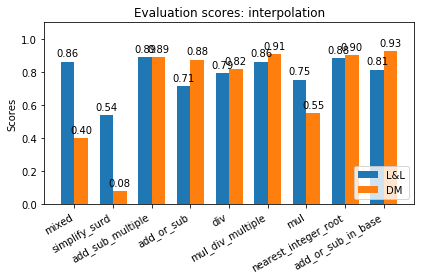

In [39]:
for epoch, job_id in job_ids.items():
    model_path = Path('../../../../storage/artifacts/'  + job_id)
    lstm_eval = LSTMWithAttentionEvaluator(model_path)
    print('EPOCH', epoch)
    res, res_dm = evaluate_arithmetics_interpolate(lstm_eval, input_texts, target_texts)

W0823 15:02:56.510111 139814115399424 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f23d0e0bb38>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0823 15:02:56.513278 139814115399424 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f23d0e11ac8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0823 15:03:01.182667 139814115399424 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f24585c72e8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


EPOCH 1
19/19 [==============================] - 31s 2s/step - loss: 1.8020 - exact_match_metric_index: 0.7612


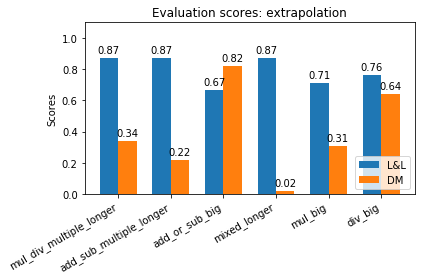

In [41]:
for epoch, job_id in job_ids.items():
    model_path = Path('../../../../storage/artifacts/'  + job_id)
    lstm_eval = LSTMWithAttentionEvaluator(model_path)
    print('EPOCH', epoch)
    res, res_dm = evaluate_arithmetics_extrapolate(lstm_eval, input_texts, target_texts)

## We can also test an indiviual string:

In [37]:
lstm_eval.predict_on_string('1 / 7')

NameError: name 'input_texts_train' is not defined

In [52]:
lstm_eval.predict_on_string('2*2')

''